In [7]:
%matplotlib inline

import pandas as pd, numpy as np, matplotlib.pyplot as plt, time

from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
from shapely.geometry import MultiPoint

In [8]:
df = pd.read_csv('C:/workfiles/denver-crime-data/crime.csv')
#read in data

In [9]:
df1 = df.drop(['INCIDENT_ID', 'OFFENSE_ID', 'OFFENSE_CODE', 'OFFENSE_CODE_EXTENSION', 'INCIDENT_ADDRESS', 
               'IS_CRIME', 'IS_TRAFFIC','LAST_OCCURRENCE_DATE','NEIGHBORHOOD_ID','OFFENSE_TYPE_ID', 'GEO_X', 'GEO_Y', 
               'REPORTED_DATE', 'FIRST_OCCURRENCE_DATE'], axis= 1)
df1.head()
#dropped the columns that are unused

,OFFENSE_CATEGORY_ID,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID
0,all-other-crimes,-104.809881,39.773188,5,521
1,larceny,-104.781434,39.785649,5,522
2,theft-from-motor-vehicle,-104.957381,39.663490,3,314
3,larceny,-104.941440,39.702698,3,312
4,larceny,-104.955370,39.717107,3,311


In [10]:
df1 = df1.dropna(axis=0, how='any')
df1.count()
#removed the n/a values and looked at the data count

OFFENSE_CATEGORY_ID    484260
GEO_LON                484260
GEO_LAT                484260
DISTRICT_ID            484260
PRECINCT_ID            484260
dtype: int64

In [11]:
#df1 = df1[df.OFFENSE_CATEGORY_ID != 'all-other-crimes']
#df1.count()
#the below code was when i was trying to create mutiple models however with the DBSCAN model 
#I kept running into performance issues with my pc for the larger datasets

In [12]:
#df1 = df1[df.OFFENSE_CATEGORY_ID != 'traffic-accident']
#df1.count()

In [13]:
#df1 = df1[df.OFFENSE_CATEGORY_ID != 'sexual-assault']
#df1.count()

In [14]:
#df1 = df1[df.OFFENSE_CATEGORY_ID != 'public-disorder']
#df1.count()

In [15]:
#df1 = df1[df.OFFENSE_CATEGORY_ID != 'larceny']
#df1.count()

In [16]:
#df1 = df1[df1.OFFENSE_CATEGORY_ID != 'other-crimes-against-persons']
#df1.count()

In [18]:
df1 = df1.loc[df1['OFFENSE_CATEGORY_ID'].isin(['white-collar-crime','robbery'])]
df1.count()
#thus the dataset used was the same for the DBSCAN as it was for the KNN model, white collar crime vs. robbery

OFFENSE_CATEGORY_ID    12876
GEO_LON                12876
GEO_LAT                12876
DISTRICT_ID            12876
PRECINCT_ID            12876
dtype: int64

In [19]:
#I used the below reference to create the DBSCAN model and graph it
#Boeing, G. (Oct 25, 2016) DBSCAN clustering to reduce spatial data set size. Retrieved from 
#https://github.com/gboeing/2014-summer-travels/blob/master/clustering-scikitlearn.ipynb 

# First, because we are dealing with distance we create a variable with the number of kilometers in one radian
kms_per_radian = 6371.0088

In [20]:
#assign the coordinates to a variable to use for the model
coords = df1.as_matrix(columns=['GEO_LAT', 'GEO_LON'])

# because we are using the haversine metric we need to covert to radians
epsilon = 1.5 / kms_per_radian

c:\python\python36-32\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [28]:
#create the model and assign it to the db variable
db = DBSCAN(eps=epsilon, min_samples=1, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
cluster_labels = db.labels_

#assign a variable to the number of clusters created
num_clusters = len(set(cluster_labels))
num_clusters

3

In [22]:
# create a panda dataframe with the clusters
clusters = pd.Series([coords[cluster_labels==n] for n in range(num_clusters)])

In [23]:
#defining a function that retures the center point of a cluster
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
#assigning the center points to a variable
centermost_points = clusters.map(get_centermost_point)

In [24]:
# separating the lat and long values of the center points
lats, lons = zip(*centermost_points)

# creating a singular point representation of clusters
rep_points = pd.DataFrame({'GEO_LON':lons, 'GEO_LAT':lats})
rep_points.tail()

,GEO_LON,GEO_LAT
0,-104.960521,39.729589
1,-104.700902,39.836771
2,-0.000002,0.000001


In [25]:
# pull information from the orgional data frame so that district id and precinct are listed for the points
rs = rep_points.apply(lambda row: df1[(df1['GEO_LAT']==row['GEO_LAT']) & (df1['GEO_LON']==row['GEO_LON'])].iloc[0], axis=1)
rs.tail()

,OFFENSE_CATEGORY_ID,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID
0,white-collar-crime,-104.960521,39.729589,6,622
1,white-collar-crime,-104.700902,39.836771,7,759
2,robbery,-0.000002,0.000001,7,759


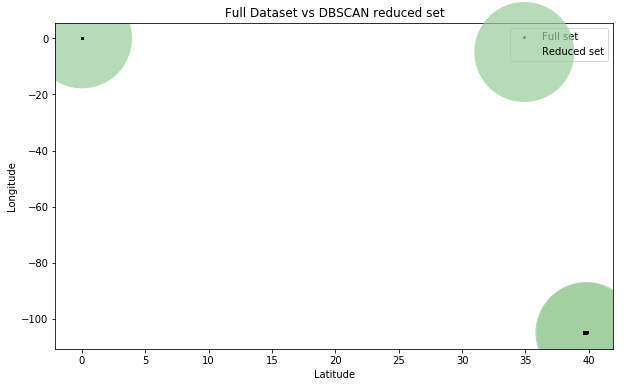

In [30]:
#create a graph of the center points with teh surrounding circle representing the entire cluster
fig, ax = plt.subplots(figsize=[10, 6])
rs_scatter = ax.scatter(rs['GEO_LAT'], rs['GEO_LON'], c='#99cc99', edgecolor='None', alpha=0.7, s=10000)
df_scatter = ax.scatter(df1['GEO_LAT'], df1['GEO_LON'], c='k', alpha=0.9, s=3)
ax.set_title('Full Dataset vs DBSCAN reduced set')
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
ax.legend([df_scatter, rs_scatter], ['Full set', 'Reduced set'], loc='upper right')
plt.show()